In [1]:
import torch
import numpy as np
import sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.physics.operators import Divergence_Operator, Laplacian_Operator

In [2]:
# load in dataset:
sample = np.load(r"C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies\2D_NS_Re40.npy")[0,100,...]
sample.shape

(64, 64)

In [122]:
S = 10
line_grid = np.linspace(0,2*np.pi,S+1, endpoint=True)[1:]
line_grid = line_grid-(line_grid[-1]-line_grid[-2])/2
X, Y = np.meshgrid(line_grid,line_grid)
coords = np.concatenate([X[...,None], Y[...,None]], axis=-1)
coords_r = coords.reshape(-1,2)

In [182]:
def create_periodic_fvm_connectivity(S):
    owner_list = []
    neighbour_list = []
    normal_list = []
    
    # Horizontal faces: (i,j) -> (i, j+1), normal points right (+x direction)
    for i in range(S):
        for j in range(S):
            owner = i * S + j
            neigh = i * S + (j + 1) % S
            owner_list.append(owner)
            neighbour_list.append(neigh)
            #normal_list.append([1.0, 0.0])  # unit normal: right (+x)
            normal_list.append([0.0, 1.0])
    
    # Vertical faces: (i,j) -> (i+1, j), normal points up (+y direction)  
    for i in range(S):
        for j in range(S):
            owner = i * S + j
            neigh = ((i + 1) % S) * S + j
            owner_list.append(owner)
            neighbour_list.append(neigh)
            #normal_list.append([0.0, 1.0])  # unit normal: up (+y)
            normal_list.append([1.0, 0.0])
    
    owner = torch.tensor(owner_list, dtype=torch.int64)
    neighbour = torch.tensor(neighbour_list, dtype=torch.int64)
    normals = torch.tensor(normal_list, dtype=torch.float32)
    
    return owner, neighbour, normals

# Usage with your grid
#S = 10  # from your line_grid with 64 points
owner, neighbour, normals = create_periodic_fvm_connectivity(S)

print(f"Shapes: owner={owner.shape}, neighbour={neighbour.shape}, normals={normals.shape}")
print(f"First 4 faces (horizontal):")
print(f"  owner: {owner[:4]}, neigh: {neighbour[:4]}, normals: {normals[:4]}")
print(f"Next 4 faces (vertical):") 
print(f"  owner: {owner[64:68]}, neigh: {neighbour[64:68]}, normals: {normals[64:68]}")

Shapes: owner=torch.Size([200]), neighbour=torch.Size([200]), normals=torch.Size([200, 2])
First 4 faces (horizontal):
  owner: tensor([0, 1, 2, 3]), neigh: tensor([1, 2, 3, 4]), normals: tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
Next 4 faces (vertical):
  owner: tensor([64, 65, 66, 67]), neigh: tensor([65, 66, 67, 68]), normals: tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


Visual Verification

In [ ]:
ARROW_LENGTH = np.pi/(2*S)
arrowo_x, arrowo_y, arrowo_x_end, arrowo_y_end = [], [], [], []
arrown_x, arrown_y, arrown_x_end, arrown_y_end = [], [], [], []
for face_idx in range(len(owner)):
    face_normal = normals[face_idx].numpy()
    arrow_vec = ARROW_LENGTH * face_normal
    
    # Outgoing arrow (when cell is owner): from center → center + normal
    owner_cell = owner[face_idx].item()
    owner_center = coords_r[owner_cell]
    arrowo_x.append(owner_center[0])
    arrowo_y.append(owner_center[1])
    arrowo_x_end.append(owner_center[0] + arrow_vec[0])
    arrowo_y_end.append(owner_center[1] + arrow_vec[1])
    
    # Incoming arrow (when cell is neighbour): from center - normal → center  
for face_idx in range(len(neighbour)):
    face_normal = normals[face_idx].numpy()
    arrow_vec = ARROW_LENGTH * face_normal
    
    neigh_cell = neighbour[face_idx].item()
    neigh_center = coords_r[neigh_cell]
    arrown_x.append(neigh_center[0] - arrow_vec[0])
    arrown_y.append(neigh_center[1] - arrow_vec[1])
    arrown_x_end.append(neigh_center[0])
    arrown_y_end.append(neigh_center[1])
    arrow_colors.append('red')  # Incoming (neighbour)

In [125]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=coords_r[:,0], y=coords_r[:,1],
    mode='markers',
    marker=dict(color='green', size=10),
    name='Cell Centres',
    showlegend=False
))
for i in range(len(owner)):
    fig.add_annotation(ax=arrowo_x[i],ay=arrowo_y[i],
    x=arrowo_x_end[i], y=arrowo_y_end[i],
    xref="x", yref="y",axref="x", ayref="y",arrowhead=2,arrowsize=1.5,arrowwidth=2,showarrow=True, arrowcolor='Blue')
for i in range(len(neighbour)):
    fig.add_annotation(ax=arrown_x[i],ay=arrown_y[i],
    x=arrown_x_end[i], y=arrown_y_end[i],
    xref="x", yref="y",axref="x", ayref="y",arrowhead=2,arrowsize=1.5,arrowwidth=2,showarrow=True, arrowcolor='Red')

fig.update_layout(
    xaxis=dict(range=[0, 2*np.pi], showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
    yaxis=dict(range=[0, 2*np.pi], showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
    width=800, height=800,
    hovermode='closest'
)
fig.show()

Now we need areas

In [ ]:
L = 2*np.pi
face_length = L/S
area = face_length # 2d assumption
volume = face_length**2 # 2d assumption

In [ ]:
print(mesh.mesh.n_cells)
print(mesh.mesh.internal_faces)
print(mesh.mesh.face_areas.shape)
print(mesh.mesh.face_owners)
print(mesh.mesh.face_neighbors)
print(mesh.correction_method)
print(mesh.mesh.dim)
print(mesh.delta.shape)

In [ ]:
from types import SimpleNamespace
class periodic_isometric_grid(object):
    def __init__(self, L=2*np.pi, S=10, device='cpu', dtype=torch.float32):
        
        self.device = torch.device(device)
        face_length = 2*np.pi/S
        cell_area = face_length**2

        self.mesh = SimpleNamespace()
        self.mesh.dim = 3 # default is 3, not sure if operators optimized for 2D
        self.mesh.n_cells = S**2
        self.mesh.patch_face_keys = {} # periodicity enforced through cell neighbours
        self.mesh.face_owners, self.mesh.face_neighbors, normals = create_periodic_fvm_connectivity(S)
        self.mesh.face_areas = normals.to(dtype)*face_length
        self.mesh.num_internal_faces = len(self.mesh.face_owners)
        self.mesh.internal_faces = torch.arange(self.mesh.num_internal_faces)
        self.mesh.face_areas_mag = torch.tensor([face_length],dtype=dtype).repeat(self.mesh.num_internal_faces)
        self.mesh.cell_volumes = torch.tensor([cell_area],dtype=dtype).repeat(self.mesh.n_cells) 

        # create cell_centres
        self.mesh.cell_centers = self.fetch_2d_grid(L, S)
        self.mesh.cell_center_vectors = self.mesh.cell_centers[self.mesh.face_neighbors] - self.mesh.cell_centers[self.mesh.face_owners]

        # none `mesh` namespace objects
        self.correction_method = None
        self.delta = normals.to(dtype)
        self.delta_mag = torch.norm(self.delta, dim=-1, keepdim=False) # should be all ones because they are unit vectors
        self.d = self.mesh.cell_center_vectors
        self.d_mag = torch.norm(self.d, dim=-1, keepdim=False)
        self.internal_face_weights = torch.tensor([0.5]).repeat(self.mesh.num_internal_faces) # equidistant on isometric mesh
        
        # expand to 3D:
        if self.mesh.dim == 3:
            self.mesh.face_areas = torch.nn.functional.pad(self.mesh.face_areas, (0, 1), value=0.0)
            self.delta = torch.nn.functional.pad(self.delta, (0, 1), value=0.0)
            self.d = torch.nn.functional.pad(self.delta, (0, 1), value=0.0)

        # send all to device
        self.to(device)
        
    def fetch_2d_grid(self,L, S):
        line_grid = np.linspace(0,2*np.pi,S+1, endpoint=True)[1:]
        line_grid = line_grid-(line_grid[-1]-line_grid[-2])/2
        X, Y = np.meshgrid(line_grid,line_grid, indexing='ij')
        coords = np.concatenate([X[...,None], Y[...,None]], axis=-1)
        coords_r = torch.tensor(coords.reshape(-1,2))
        return coords_r

    def to(self,device):
        for attr_name, attr_value in vars(self.mesh).items():
            if isinstance(attr_value, torch.Tensor):
                setattr(self.mesh, attr_name, attr_value.to(device))

        for attr_name, attr_value in vars(self).items():
            if isinstance(attr_value, torch.Tensor):
                setattr(self, attr_name, attr_value.to(device))


In [174]:
def periodic_derivatives(x, dx=1.0, dy=1.0):
    """
    Compute first and second derivatives with 2nd-order central differences
    and periodic BCs.
    
    x: tensor of shape (B, N, N) or (B, N, N, C)
    dx, dy: grid spacing
    
    Returns:
        dx1, dy1 : first derivatives
        dx2, dy2 : second derivatives
    """

    # shift along x-direction (dim=1)
    x_ip = torch.roll(x, shifts=-1, dims=1)
    x_im = torch.roll(x, shifts=+1, dims=1)

    # shift along y-direction (dim=2)
    y_ip = torch.roll(x, shifts=-1, dims=2)
    y_im = torch.roll(x, shifts=+1, dims=2)

    # First derivatives: (f[i+1] - f[i-1]) / (2*dx)
    dx1 = (x_ip - x_im) / (2.0 * dx)
    dy1 = (y_ip - y_im) / (2.0 * dy)

    # Second derivatives: (f[i+1] - 2f[i] + f[i-1]) / dx^2
    dx2 = (x_ip - 2.0 * x + x_im) / (dx * dx)
    dy2 = (y_ip - 2.0 * x + y_im) / (dy * dy)

    return dx1, dy1, dx2, dy2

In [229]:
mesh = periodic_isometric_grid(S=64)

In [211]:
sample_t = torch.tensor(sample, dtype=torch.float32).reshape(1,1,-1,1)
#sample_t = torch.nn.functional.pad(sample_t, (0, 1), value=0.0)

In [230]:
_, gradp_pred = Divergence_Operator.caclulate(mesh, field=sample_t, field_type='p')
gradp_pred = gradp_pred[0,0,:,0].reshape(64,64)

In [178]:
dx1, dy1, dx2, dy2 = periodic_derivatives(torch.tensor(sample).unsqueeze(0), dx=2*np.pi/64, dy=2*np.pi/64)

In [235]:
import plotly.graph_objects as go
import plotly.subplots as subplots
rows=1
cols=4
fig = subplots.make_subplots(rows,cols, subplot_titles=('Dataset', 'FVM', 'FDM', 'Difference'))
fig.add_trace(go.Heatmap(z=sample, showscale=False),1,1)
fig.add_trace(go.Heatmap(z=gradp_pred, showscale=False),1,2)
fig.add_trace(go.Heatmap(z=dx1[0,...], showscale=False),1,3)
fig.add_trace(go.Heatmap(z=gradp_pred-dx1[0,...], showscale=True),1,4)
#fig.add_trace(go.Heatmap(z=first_soblev[0,...,0].real, showscale=False),1,3)
for i in range(1, rows*cols + 1):
    fig.update_xaxes(scaleanchor=f"y{i}", scaleratio=1, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
    fig.update_yaxes(constrain='domain', row=(i-1)//cols + 1, col=(i-1)%cols + 1)
fig.show()

## Unstructured Geometry

### Option 1
This is harder to wrap around. We can either interpolate onto a mesh or we can try Option 2, which is solve for an airfoil, using the meshing provided by geo-fno.

In [238]:
import pyvista as pv
pv.set_jupyter_backend('static')

In [239]:
vortex_case_dir = r"C:\Users\Noahc\Documents\USYD\tutorial\LESvortexShed\case.foam"
vtk_file_reader = pv.OpenFOAMReader(vortex_case_dir)
#vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
vtk_file_reader.set_active_time_value(0)
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
vtk_mesh = vtk_file_reader.read()

In [251]:
cell_centers = vtk_mesh['internalMesh'].cell_centers().points

In [257]:
vtk_mesh['internalMesh']['index'] = np.arange(cell_centers.shape[0])
print('Cell count', cell_centers.shape[0])

Cell count 123200


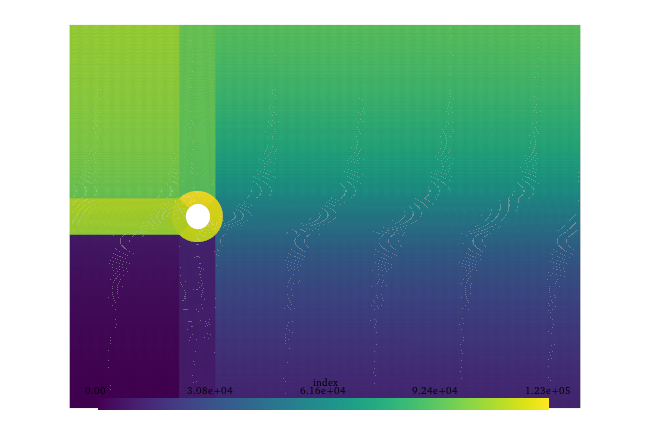

In [ ]:
dpi = 100
latex_textwidth = 6.5
aspect_ratio =1.5
width_pixels = int(latex_textwidth * dpi)
height_pixels = int(latex_textwidth * dpi / aspect_ratio)
pl = pv.Plotter(window_size=[width_pixels,height_pixels])
pl.set_background('white', top='white') 
pl.add_mesh(vtk_mesh['internalMesh'], scalars='index', show_edges=True, opacity=1, lighting=False,
            edge_opacity=0.1, interpolate_before_map=False, show_scalar_bar=False)
pl.add_scalar_bar(title='index', title_font_size=int(10*dpi/100), 
                label_font_size=int(10*dpi/100), font_family='times',
                vertical=False, position_x=0.15, position_y=0.05, width=0.7, height=0.08,
                #n_labels= len(ticks), fmt= "%.0e",  # scientific notation
                # tick_locations= ticks
                )

pl.camera_position = 'xy'
pl.camera.zoom(1.5)
pl.show()

### Option 2

In [3]:
import sys
import numpy as np
sys.path.append(r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Geo-FNO')
from airfoils.naca_design import NACA_shape, GeoSpace, NACA_shape_mesh, NACA_sdesign, Cgrid2Cylinder, Cylinder2Cgrid, Theta2Mesh

In [4]:
cnx1=50
dy0=2.0 / 120.0
cnx2=120
cny=50
R=40
Rc=1.0
L=40
cnx = 2 * cnx1 + cnx2
nx1, nx2, ny = cnx1 + 1, cnx2 + 1, cny + 1  # points
nnodes = (2 * nx1 + cnx2 - 1) * cny + (nx1 + cnx2 - 1)

xx_airfoil, yy_airfoil = NACA_shape_mesh(cnx2 // 2 + 1, method="stretching")
xx_inner = GeoSpace(0, 1, nx1, dx0=np.sqrt((xx_airfoil[0] - xx_airfoil[1]) ** 2 + (yy_airfoil[0] - yy_airfoil[1]) ** 2) / (L - 1))
xx_outer = GeoSpace(Rc, L, nx1)
wy = GeoSpace(0, 1, ny, dx0=dy0 / R)

In [9]:
wy.shape

(51,)

mesh looks like it is too big to solve

### Option 3
recreate circular mesh for vortex shedding, but using python so we can unwrap it.

In [12]:
grid

StructuredGrid,Information
N Cells,0
N Points,1000
X Bounds,"-1.000e+00, 1.000e+00"
Y Bounds,"-9.980e-01, 9.980e-01"
Z Bounds,"0.000e+00, 0.000e+00"
Dimensions,"0, 0, 0"
N Arrays,0


In [14]:
grid.n_cells

0

In [26]:
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')

n_theta, n_r = 51, 20  # one extra point to close the circle
r_inner, r_outer = 0.2, 1.0

ratio = (r_outer - r_inner) / r_inner
radii = r_inner * np.exp(np.linspace(0, np.log(1 + ratio), n_r))
theta = np.linspace(0, 2 * np.pi, n_theta, endpoint=True)  # includes 2π

theta_mesh, r_mesh = np.meshgrid(theta, radii, indexing='ij')
x = r_mesh * np.cos(theta_mesh)
y = r_mesh * np.sin(theta_mesh)
z = np.zeros_like(x)

grid = pv.StructuredGrid(x, y, z)

print(f"Points: {grid.n_points}, Cells: {grid.n_cells}, Dims: {grid.dimensions}")

# plotter = pv.Plotter()
# plotter.add_mesh(grid, show_edges=True, line_width=1)
# plotter.show()

Points: 1020, Cells: 950, Dims: (51, 20, 1)


In [ ]:
# Assume grid is your StructuredGrid (annulus)
x = grid.points[:, 0]
y = grid.points[:, 1]

cell_centers = grid.cell_centers().points  # shape (n_cells,3)
cx = cell_centers[:, 0]

# Create label array: zeros
boundary_labels = np.zeros(grid.n_cells, dtype=int)

# Label boundaries (example): cells with centers x <= 0 as inlet (1), x > 0 as outlet (2)
boundary_labels[cx <= 0] = 1  # inlet
boundary_labels[cx > 0] = 2   # outlet

# Identify inner cylinder boundary cells: where radius close to inner radius
r_inner = 0.2
radii = np.linalg.norm(cell_centers[:, :2], axis=1)
inner_threshold = r_inner + 1e-4
boundary_labels[radii <= inner_threshold] = 3  # wall (inner cylinder)

# Add as cell array to grid
grid.cell_data['BoundaryID'] = boundary_labels

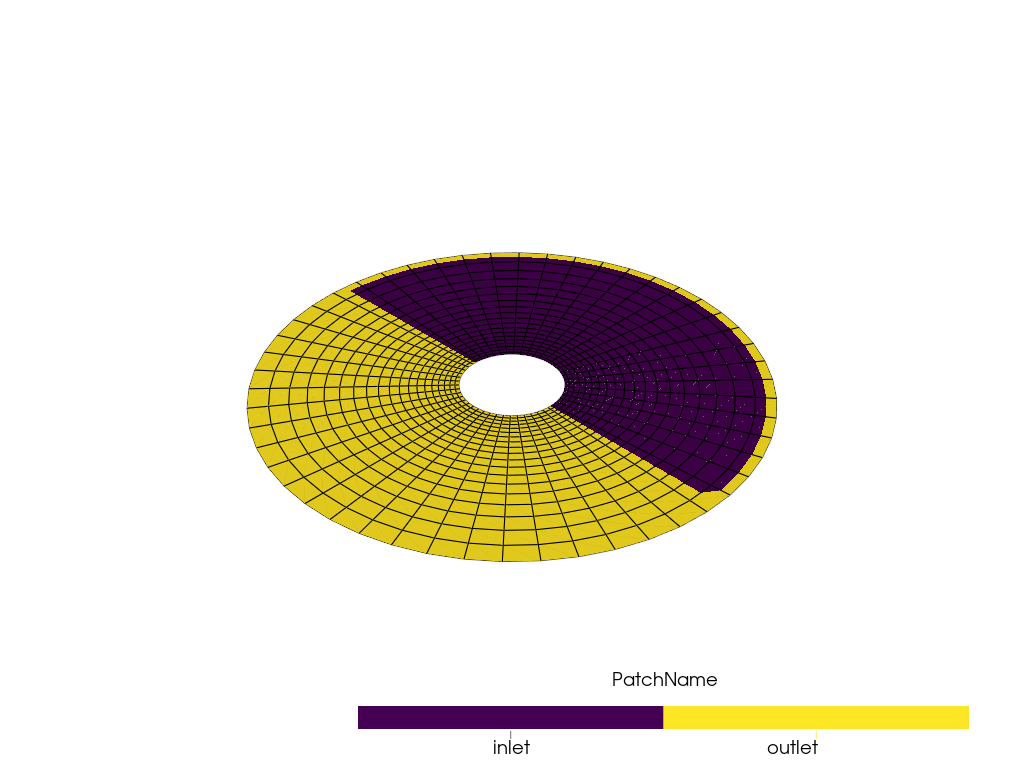

In [39]:
plotter = pv.Plotter()
plotter.add_mesh(boundary_edges, show_edges=True, line_width=1, scalars='PatchName')
plotter.show()

### Option 4
Take already created mesh and unravel it:

- [https://tariqkhamlaj.com/laminar-flow-over-circular-cylinder/](https://tariqkhamlaj.com/laminar-flow-over-circular-cylinder/)
- [https://github.com/khamlajt1/Laminar-Flow-over-a-Circular-Cylinder/tree/master](https://github.com/khamlajt1/Laminar-Flow-over-a-Circular-Cylinder/tree/master)

In [24]:
import pyvista as pv
import numpy as np
pv.set_jupyter_backend('static')
vortex_case_dir = r"C:\Users\Noahc\Documents\USYD\tutorial\Laminar-Flow-over-a-Circular-Cylinder\CaseFile\case.foam"
vortex_case_dir = r"C:\Users\Noahc\Documents\USYD\tutorial\cylinder_mno_turb5\case.foam"
vtk_file_reader = pv.OpenFOAMReader(vortex_case_dir)
vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
#vtk_file_reader.set_active_time_value(0)
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
vtk_mesh = vtk_file_reader.read()

In [2]:
vtk_mesh['internalMesh']

UnstructuredGrid (0x1e2c92a6340)
  N Cells:    21004
  N Points:   42720
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -1.000e+01, 1.000e+01
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   2

In [3]:
vtk_mesh['boundary']

MultiBlock (0x1e2c929dee0)
  N Blocks    5
  X Bounds    -10.000, 10.000
  Y Bounds    -10.000, 10.000
  Z Bounds    0.000, 1.000

In [4]:
vtk_mesh['boundary']['cylinder']

PolyData (0x1e2c92b2520)
  N Cells:    356
  N Points:   712
  N Strips:   0
  X Bounds:   -5.000e-01, 5.000e-01
  Y Bounds:   -5.000e-01, 5.000e-01
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   2

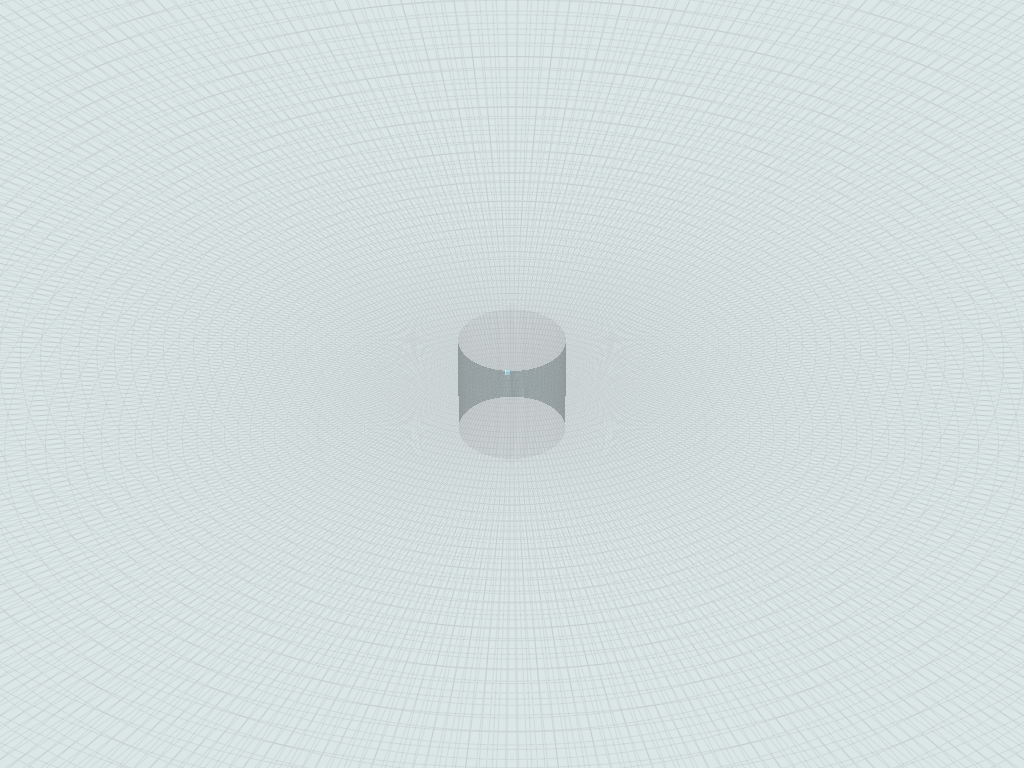

In [7]:
plotter = pv.Plotter()
plotter.add_mesh(vtk_mesh['internalMesh'], show_edges=True, line_width=1, color='lightBlue', edge_opacity=0.4, opacity=0.2)
plotter.add_mesh(vtk_mesh['boundary']['inlet'], show_edges=True, line_width=1, color='Red', edge_color='Red')
plotter.add_mesh(vtk_mesh['boundary']['exit'], show_edges=True, line_width=1, color='Green', edge_color='Green')
#plotter.add_mesh(vtk_mesh['boundary']['cylinder'], show_edges=True, line_width=1, color='Purple', edge_color='Purple')
plotter.add_points(np.array([[0.39578074, 0.34350225,  1]]))
#plotter.camera_position = 'xy'
plotter.camera.zoom(4)
plotter.show()

In [19]:
total_cells = vtk_mesh['internalMesh'].n_cells
n_angles = vtk_mesh['boundary']['cylinder'].n_cells
assert (vtk_mesh['boundary']['inlet'].n_cells + vtk_mesh['boundary']['exit'].n_cells) == n_angles
n_radii = int(total_cells/n_angles)
print('Number of radii', n_radii, 'and Number of angles', n_angles)
#length

Number of radii 59 and Number of angles 356


In [9]:
class AngularMeshRavel:
    def __init__(self, points, m=59, n=356):
        """
        Initialize the mesh unravel/ravel utility for an angular mesh.
        
        points : ndarray of shape [p, 2], Cartesian coordinates of mesh points
        m : int, number of radial layers expected
        n : int, number of angular points expected per layer
        
        This class sorts and groups points into radial layers and angular order,
        allowing forward unraveling to shape [m, n, 2] and inverse raveling to original [p, 2].
        """
        self.points = points
        self.m = m
        self.n = n
        
        # Compute polar coordinates for sorting and grouping
        x, y = points[:, 0], points[:, 1]
        self.r = np.sqrt(x**2 + y**2)
        self.theta = np.arctan2(y, x)
        
        # Sort points by radius and group indices to m radial layers
        sort_idx = np.argsort(self.r)
        p = points.shape[0]
        group_size = p // m
        self.radius_groups = []
        for i in range(m):
            start = i * group_size
            end = min((i+1) * group_size, p) if i < m-1 else p
            group_idx = sort_idx[start:end]
            self.radius_groups.append(group_idx)
    
    def _compute_unique_coords(self):
        """Compute representative radii and angles for each layer."""
        self.unique_radii = np.zeros(self.m)
        self.unique_angles = np.zeros(self.n)
        
        # Representative radius: mean radius per layer
        for i, group_idx in enumerate(self.radius_groups):
            self.unique_radii[i] = np.mean(self.r[group_idx])
        
        # Representative angles: evenly spaced (for plotting continuity)
        # Could use mean angles per angular position across radii if desired
        self.unique_angles = np.linspace(0, 2*np.pi, self.n, endpoint=False)
        return self.unique_angles, self.unique_radii

    def to(self, arr, forward=True):
        """
        Transform arr between unraveled [m, n, ...] and raveled [p, ...] formats.
        
        arr : input data array to transform (coordinates, scalar or vector values)
              Shape must align with either [p, ...] if forward=True or [m, n, ...] if forward=False
        forward : bool, True = forward unraveling [p, ...] -> [m, n, ...], 
                        False = inverse raveling [m, n, ...] -> [p, ...]
        
        Returns transformed array with reshaped/reordered data.
        """
        if forward:
            # Validate input shape
            assert arr.shape[0] == self.points.shape[0], f"Input length {arr.shape[0]} mismatch, expected {self.points.shape[0]}"
            # Initialize output container
            out_shape = (self.m, self.n) + arr.shape[1:]
            unraveled = np.zeros(out_shape, dtype=arr.dtype)
            
            for i, group_idx in enumerate(self.radius_groups):
                group_arr = arr[group_idx]
                # sort group by angle for continuity
                group_theta = self.theta[group_idx]
                sort_order = np.argsort(group_theta)
                sorted_arr = group_arr[sort_order]
                length = min(self.n, sorted_arr.shape[0])
                unraveled[i, :length] = sorted_arr[:length]
            
            return unraveled
        else:
            # inverse transform from [m, n, ...] to [p, ...]
            # initialize output container
            p = self.points.shape[0]
            raveled = np.zeros((p,) + arr.shape[2:], dtype=arr.dtype) if arr.ndim > 3 else np.zeros((p,), dtype=arr.dtype)
            idx_pos = 0
            for i, group_idx in enumerate(self.radius_groups):
                length = len(group_idx)
                data_to_ravel = arr[i, :min(self.n, length)]
                # reorder to original order before grouping (angular ordering was applied)
                group_theta = self.theta[group_idx]
                sort_order = np.argsort(group_theta)
                inv_sort_order = np.argsort(sort_order)
                data_original_order = data_to_ravel[inv_sort_order]
                raveled[group_idx] = data_original_order
                idx_pos += length
            
            return raveled
            

In [25]:
mapper = AngularMeshRavel(vtk_mesh['internalMesh'].cell_centers().points[...,:2], m=59, n=356)
angles, radii = mapper._compute_unique_coords()
coords_mapped = mapper.to(vtk_mesh['internalMesh'].cell_centers().points[...,:2])

In [26]:
import plotly.graph_objects as go
fig = go.Figure(
    data=go.Heatmap(
        z=coords_mapped[...,0],    # data matrix [m (radius), n (angle)]
        colorscale='Viridis',  # colorscale choice
        x=angles,   # angular indices
        y=radii,   # radial indices
        hoverongaps=False,
        zsmooth=False
    )
)
fig.show()

In [14]:
vtk_mesh['internalMesh']['x_coord'] = vtk_mesh['internalMesh'].cell_centers().points[:,0]
vtk_mesh['internalMesh']['y_coord'] = vtk_mesh['internalMesh'].cell_centers().points[:,1]

In [22]:
vtk_mesh['internalMesh']

UnstructuredGrid (0x1e2da46dd00)
  N Cells:    21004
  N Points:   42720
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -1.000e+01, 1.000e+01
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   2

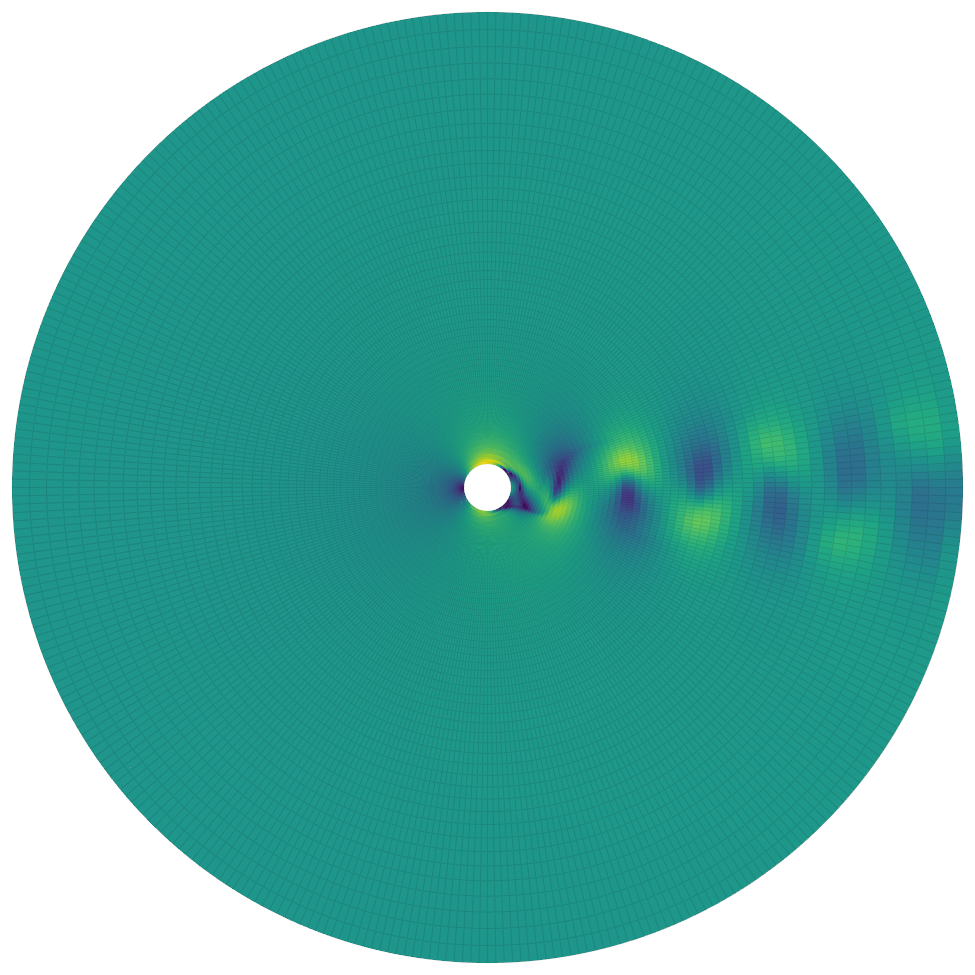

In [79]:
figure_path = r"C:\Users\Noahc\Documents\USYD\PHD\4 - Latex_new\00_figures\06_mno\circle"
latex_textwidth_in_inches = 6.5  # change as needed
px_width = latex_textwidth_in_inches * 96
dpi = 300
aspect_ratio = 1
width_pixels = int(latex_textwidth_in_inches * dpi)
height_pixels = int(latex_textwidth_in_inches * dpi / aspect_ratio)
plotter = pv.Plotter(window_size=[int(width_pixels/2),int(height_pixels/2)])
plotter.add_mesh(vtk_mesh['internalMesh'], show_edges=True, line_width=1, edge_opacity=0.1, opacity=1, scalars='U', show_scalar_bar=False, cmap='viridis', lighting=False)
plotter.camera_position = 'xy'
plotter.camera.zoom(1.4)
plotter.show()
plotter.save_graphic(f'{figure_path}/cylinder_diagram_mesh.pdf')

In [48]:
U_mapped.shape

(59, 356, 3)

In [ ]:
U_mapped = mapper.to(vtk_mesh['internalMesh']['U'])
fig = go.Figure(
    data=go.Heatmap(
        z=np.sqrt(U_mapped[...,0]**2 + U_mapped[...,1]**2),    # data matrix [m (radius), n (angle)]
        colorscale='Viridis',  # colorscale choice
        x=angles,   # angular indices
        y=radii,   # radial indices
        hoverongaps=False,
        zsmooth=False,
        showscale=False
    )
)
fig.update_layout(
    font=dict(family="Times New Roman", size=11), template = "simple_white",
    xaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Angle', scaleanchor='y', scaleratio=1.5, title_standoff=0),
    yaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Radius'),
    plot_bgcolor='rgba(0,0,0,0)',    # Background color inside the plot area
    width=px_width/2, showlegend=False, margin=dict(l=20, r=10, t=20, b=10), height = px_width/2, 
)
fig.update_xaxes(
    tickmode="array",
    range=[0, 2*np.pi],
    tickvals=[0, np.pi, 2*np.pi],
    ticktext=["0", "π", "2π"]
)
fig.show()
fig.write_image(f'{figure_path}/cylinder_diagram_mesh_unwrapped.pdf')

In [ ]:
coords_mapped = mapper.to(vtk_mesh['internalMesh']['x_coord'])
coords_mapped_back = mapper.to(coords_mapped, forward=False)
vtk_mesh['internalMesh']['x_coord_back'] = coords_mapped_back
vtk_mesh['internalMesh']['dif'] = vtk_mesh['internalMesh']['x_coord_back'] - vtk_mesh['internalMesh']['x_coord']

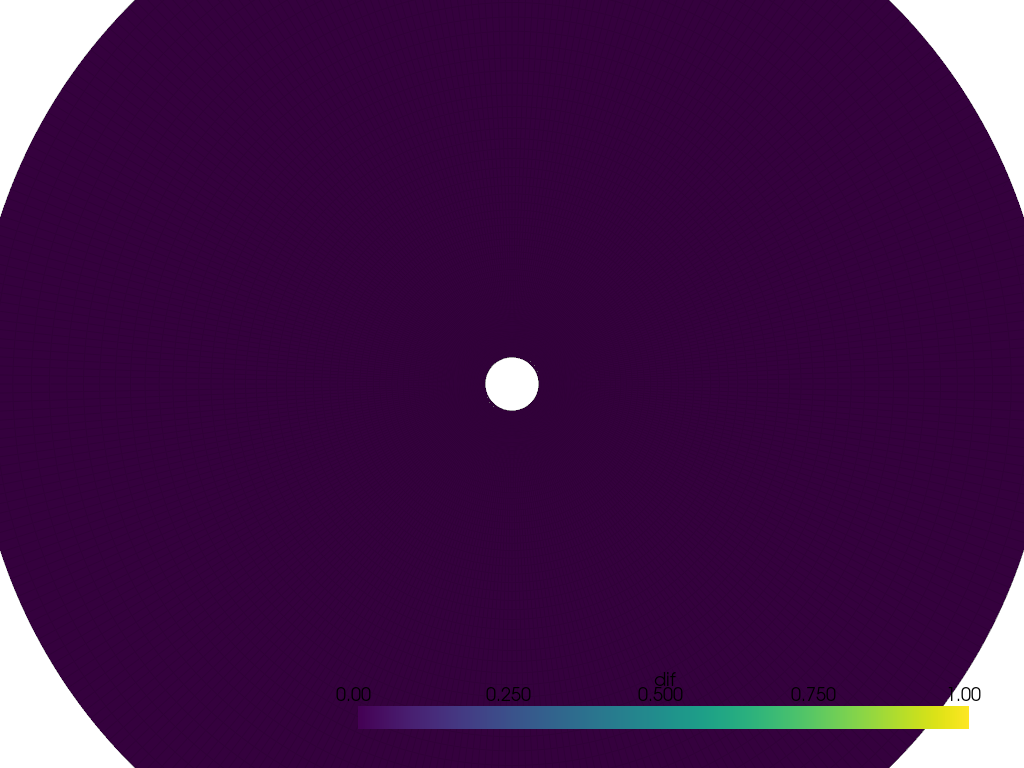

In [ ]:
plotter = pv.Plotter()
plotter.add_mesh(vtk_mesh['internalMesh'], show_edges=True, line_width=1, color='lightBlue', edge_opacity=0.1, opacity=1, scalars='dif')
plotter.camera_position = 'xy'
plotter.camera.zoom(2)
plotter.show()

**Success!**
We have a wrapper for the mesh that translates the angular mesh into rectilinear one. This can be used with geo-FNO
